In [ ]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from datetime import datetime, timedelta
from arch import arch_model
from pandas_datareader import data as web
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Stock volatility time period
start = datetime(2010, 6, 1)
end = datetime(2020, 6, 1)

In [ ]:
# Get the data
stock = web.DataReader("GC=F", data_source = "yahoo", start = start, end = end)

In [ ]:
# Take a look of the data
stock.head()
stock.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-27,1710.300049,1685.599976,1685.599976,1710.300049,137416.0,1710.300049
2020-05-28,1727.800049,1705.000000,1709.300049,1713.300049,23355.0,1713.300049
2020-05-29,1738.300049,1715.099976,1718.800049,1736.900024,1526.0,1736.900024
2020-05-31,1758.599976,1740.400024,1749.800049,1755.099976,444305.0,1755.099976
2020-06-01,1747.000000,1727.099976,1740.400024,1737.800049,871.0,1737.800049


In [ ]:
# Calculate the simple returns
stock["Simple_Return"] = (stock["Adj Close"] / stock["Adj Close"].shift(1)) - 1

In [ ]:
# Show the data with simple returns
stock.tail()

,High,Low,Open,Close,Volume,Adj Close,Simple_Return
Date,,,,,,,
2020-05-27,1710.300049,1685.599976,1685.599976,1710.300049,137416.0,1710.300049,0.003226
2020-05-28,1727.800049,1705.000000,1709.300049,1713.300049,23355.0,1713.300049,0.001754
2020-05-29,1738.300049,1715.099976,1718.800049,1736.900024,1526.0,1736.900024,0.013775
2020-05-31,1758.599976,1740.400024,1749.800049,1755.099976,444305.0,1755.099976,0.010478
2020-06-01,1747.000000,1727.099976,1740.400024,1737.800049,871.0,1737.800049,-0.009857


In [ ]:
# Calculate the log returns
stock["Log_Return"] = np.log(stock["Adj Close"] / stock["Adj Close"].shift(1))

In [ ]:
# Show the data with log returns
stock.tail()

,High,Low,Open,Close,Volume,Adj Close,Simple_Return,Log_Return
Date,,,,,,,,
2020-05-27,1710.300049,1685.599976,1685.599976,1710.300049,137416.0,1710.300049,0.003226,0.003221
2020-05-28,1727.800049,1705.000000,1709.300049,1713.300049,23355.0,1713.300049,0.001754,0.001753
2020-05-29,1738.300049,1715.099976,1718.800049,1736.900024,1526.0,1736.900024,0.013775,0.013681
2020-05-31,1758.599976,1740.400024,1749.800049,1755.099976,444305.0,1755.099976,0.010478,0.010424
2020-06-01,1747.000000,1727.099976,1740.400024,1737.800049,871.0,1737.800049,-0.009857,-0.009906


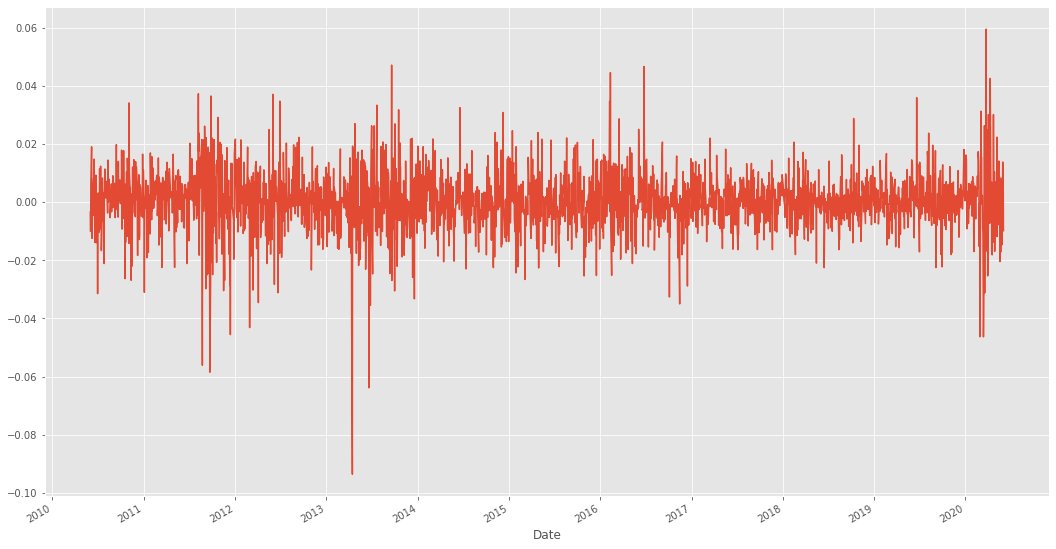

In [ ]:
# Plot the simple return
stock["Simple_Return"].plot(figsize = (18, 10))

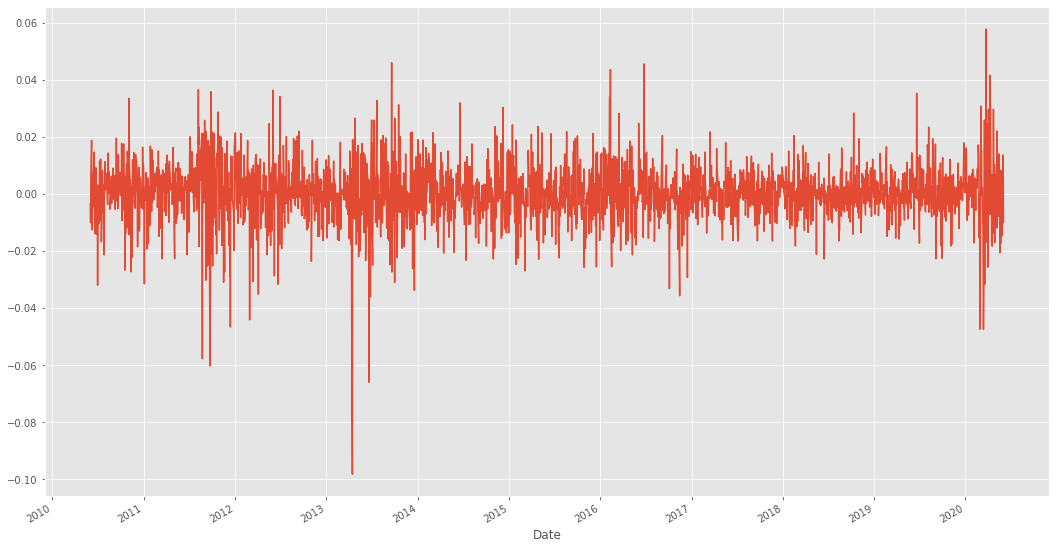

In [ ]:
# Plot the log return
stock["Log_Return"].plot(figsize = (18, 10))

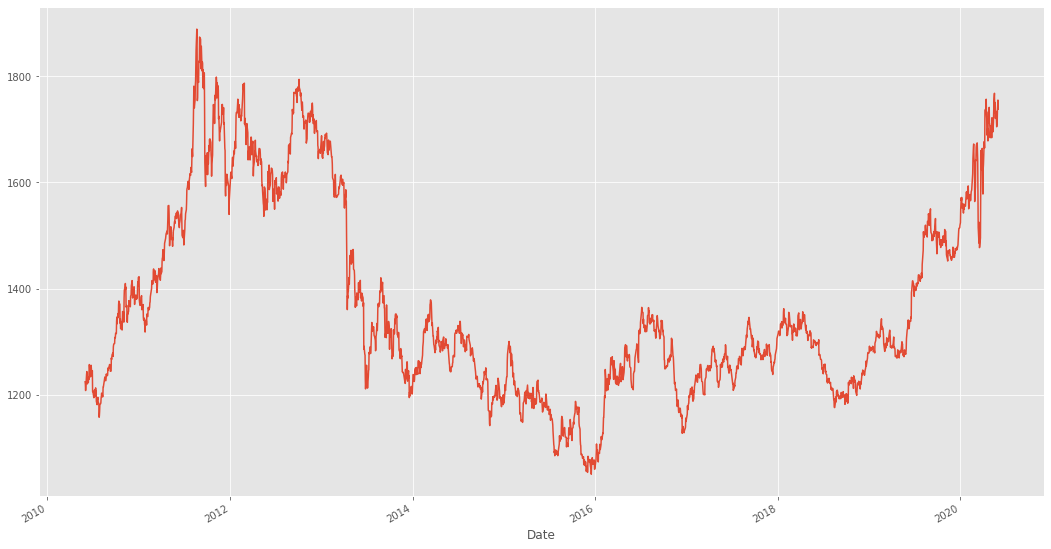

In [ ]:
stock["Adj Close"].plot(figsize = (18, 10))

In [ ]:
# Simple return in percent
pct_return = 100 * stock["Adj Close"].pct_change().dropna()

In [ ]:
# Take a look at the last 5 percent return
pct_return.tail(10)

Date
2020-05-19    0.632982
2020-05-20    2.111140
2020-05-21    0.437875
2020-05-22   -0.735758
2020-05-26   -0.112843
2020-05-27    3.166450
2020-05-28    1.880304
2020-05-29    0.950466
2020-06-01    2.566210
2020-06-02    1.556553
Name: Adj Close, dtype: float64

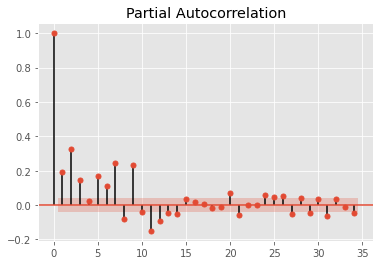

In [ ]:
# PACF plot for simple return
plot_pacf(pct_return ** 2);

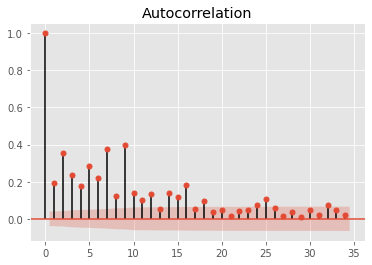

In [ ]:
# ACF plot for simple return
plot_acf(pct_return ** 2);

In [ ]:
# Fitting the GARCH(3, 3)
model = arch_model(pct_return, p = 2
                   , q = 1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 3355.094628623173
Iteration:      2,   Func. Count:     18,   Neg. LLF: 3353.0287353381623
Iteration:      3,   Func. Count:     28,   Neg. LLF: 3353.014872732815
Iteration:      4,   Func. Count:     36,   Neg. LLF: 3352.8510723380223
Iteration:      5,   Func. Count:     44,   Neg. LLF: 3352.7916371579927
Iteration:      6,   Func. Count:     54,   Neg. LLF: 3352.7772368045044
Iteration:      7,   Func. Count:     62,   Neg. LLF: 3352.7066839104073
Iteration:      8,   Func. Count:     71,   Neg. LLF: 3352.692952964094
Iteration:      9,   Func. Count:     79,   Neg. LLF: 3352.6857784803697
Iteration:     10,   Func. Count:     86,   Neg. LLF: 3352.6855334521506
Iteration:     11,   Func. Count:     93,   Neg. LLF: 3352.6855037097835
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3352.685503709845
            Iterations: 11
            Function evaluations: 93
            Gradient evalua

In [ ]:
# Summary of the model
model_fit.summary

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -3352.69
Distribution:                  Normal   AIC:                           6715.37
Method:            Maximum Likelihood   BIC:                           6744.38
                                        No. Observations:                 2446
Date:                Sun, Sep 20 2020   Df Residuals:                     2441
Time:                        13:56:26   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0695  

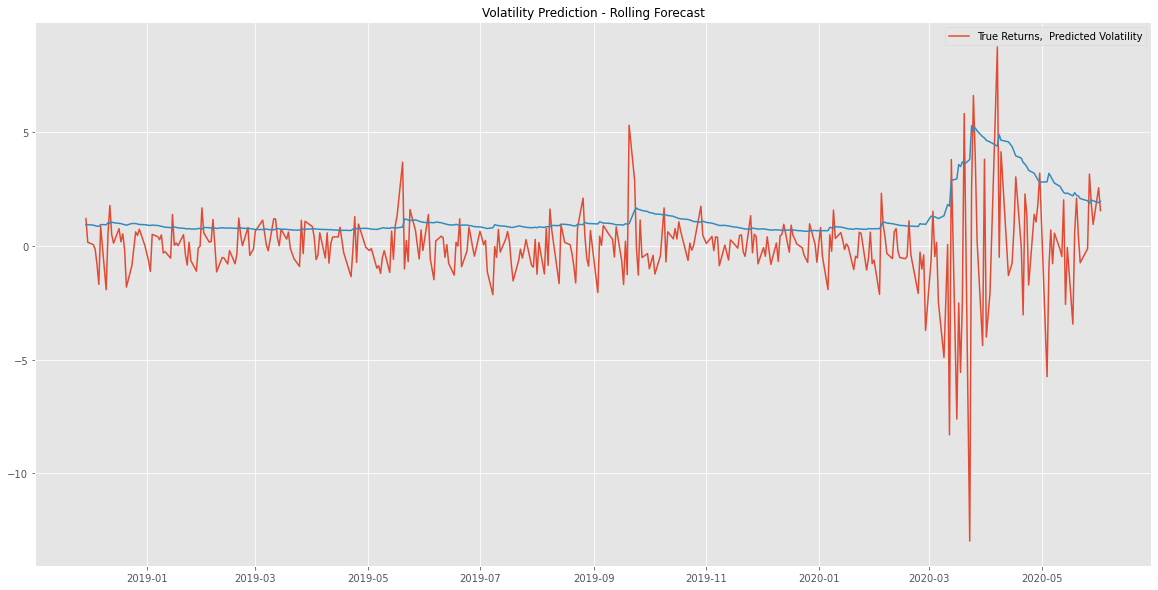

In [ ]:
# Applying rolling forecast
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = pct_return[:-(test_size-i)]
    model = arch_model(train, p = 1, q = 1)
    model_fit = model.fit(disp = "off")
    pred = model_fit.forecast(horizon = 1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

# Get the rolling prediction series
rolling_predictions = pd.Series(rolling_predictions, index = pct_return.index[-365:])

# Plotting the volatility on the percent returns
plt.figure(figsize = (20, 10))
true = plt.plot(pct_return[-365:])
preds = plt.plot(rolling_predictions)
plt.title("Volatility Prediction - Rolling Forecast", fontsize = 12)
plt.legend(["True Returns,  Predicted Volatility"], fontsize = 10)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

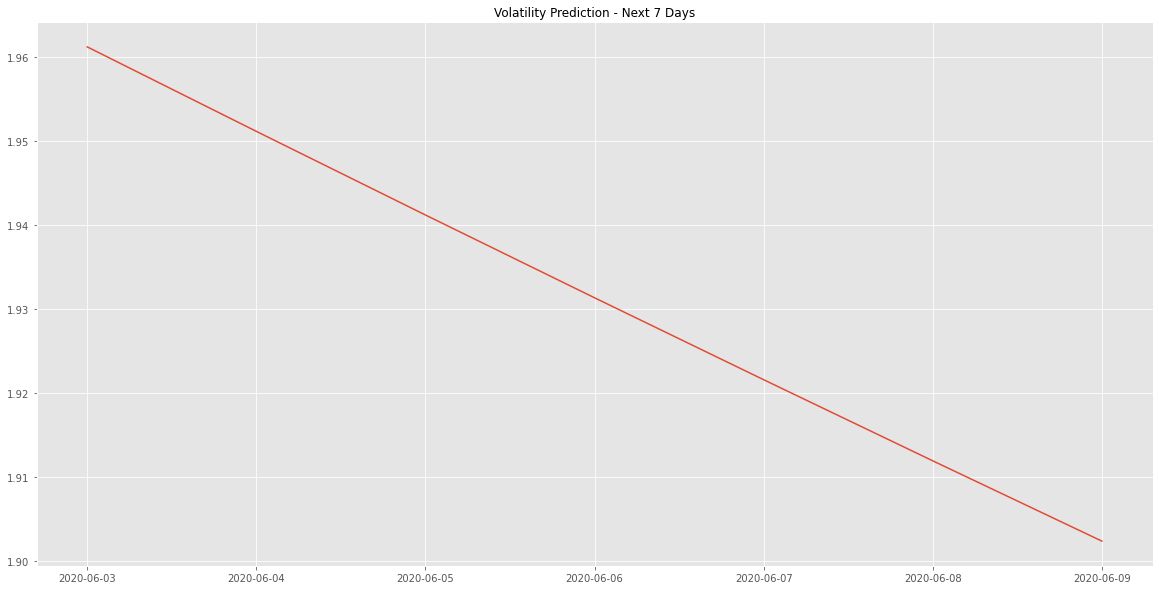

In [ ]:
# Predicting the Volatility for the future
pred = model_fit.forecast(horizon = 7)
future_dates = [pct_return.index[-1] + timedelta(days = i) for i in range(1, 8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1, :]), index = future_dates)

# Ploting the Predicted Volatility for the future
plt.figure(figsize = (20, 10))
plt.plot(pred)
plt.title("Volatility Prediction - Next 7 Days", fontsize = 12)